## ML Model Gold Standard

### Datasource
    1. https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

### Objective
    1. To classify a person into abnormal or normal using collected physical spine data.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# --------------- End of sklearn libraries ---------------------

import optuna

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.1  # test_size where used is assigned TESTSIZE

#### I/O Path & File Name

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\MLM_V3.0_LowerBackPain_I1_"

# Specify number of features and targets

n_features = 12
n_target = 1

#### Dataframe Construction

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

#### Encoding

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


#### Imputing

In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



#### Outlier Treatment

In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



#### Descriptive Stats

In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     298 |  59.763 | 16.223 |  26.148 |  46.399 |  57.701 |  72.476 |  96.657 |
| pelvic_tilt              |     298 |  16.999 |  9.288 |  -6.555 |  10.667 |  16.015 |  21.462 |   46.55 |
| lumbar_lordosis_angle    |     298 |  51.529 | 18.208 |      14 |  36.676 |  48.849 |  62.818 | 100.744 |
| sacral_slope             |     298 |  42.765 | 12.297 |  13.367 |  33.428 |   42.46 |  52.475 |  78.794 |
| pelvic_radius            |     298 | 117.703 | 12.318 |  78.999 |  110.89 | 118.172 | 125.316 |  151.84 |
| degree_spondylolisthesis |     298 |   23.02 | 27.512 | -11.058 |   1.485 |   9.893 |  39.384 | 124.984 |
| pelvic_slope             |     298 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |

#### Train-Test Split

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    178
0    90 
Name: Class_att, dtype: int64
After Upsampling: 0    178
1    178
Name: Class_att, dtype: int64


#### Random Under Sampling

In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,62.141,13.961,58.000,48.180,133.282,4.955,0.122,33.877,16.382,9.662,-16.784,43.840
1,85.352,15.845,71.669,69.507,124.420,76.021,0.047,26.050,11.788,14.397,-12.551,39.849
2,48.031,3.970,58.345,44.061,125.351,35.000,0.821,22.631,14.823,8.354,-32.827,38.807
3,45.541,13.070,30.298,32.471,117.981,-4.987,0.567,23.889,9.102,7.710,-19.379,20.365
4,42.918,-5.846,58.000,48.764,121.607,-3.362,0.543,12.470,8.598,9.078,-27.627,12.728


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
246,77.655,22.433,93.893,55.222,123.056,61.211,0.925,14.950,15.049,7.577,0.308,33.720
247,60.044,14.310,58.039,45.735,105.132,30.409,0.415,17.683,16.526,10.352,1.270,10.421
133,33.789,3.675,25.500,30.114,128.325,-1.776,0.390,9.673,11.313,13.237,-2.244,10.292
291,41.353,16.577,30.706,24.775,113.267,-4.498,0.982,29.256,16.706,16.388,-3.494,14.527
272,53.942,9.307,43.100,44.635,124.398,25.082,0.872,17.552,17.540,16.736,-17.875,19.584


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Class_att
0,0
1,1
2,1
3,1
4,0


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Class_att
246,1
247,1
133,0
291,1
272,1


#### Feature Scaling

In [30]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.251442,-0.244974,0.488086,0.518733,1.202403,-0.492424,-1.179458,1.337783,1.048457,-0.751726,-0.216979,1.683401
1,1.768813,-0.029935,1.292468,2.364854,0.460612,2.245510,-1.438162,0.460989,-0.347777,0.912050,0.124679,1.308058
2,-0.670971,-1.385341,0.508388,0.162182,0.538541,0.665108,1.231663,0.077986,0.574637,-1.211329,-1.511859,1.210061
3,-0.833749,-0.346672,-1.142099,-0.841079,-0.078363,-0.875456,0.355519,0.218910,-1.164121,-1.437617,-0.426430,-0.524360
4,-1.005223,-2.505734,0.488086,0.569286,0.225150,-0.812851,0.272734,-1.060266,-1.317300,-0.956931,-1.092151,-1.242599


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,1.265638,0.722016,2.600288,1.128307,0.346438,1.674930,1.590400,-0.782453,0.643324,-1.484350,1.162568,0.731642
1,0.114355,-0.205139,0.490381,0.307088,-1.153885,0.488233,-0.168787,-0.476297,1.092222,-0.509275,1.240214,-1.459567
2,-1.602012,-1.419012,-1.424448,-1.045107,0.787479,-0.751747,-0.255022,-1.373591,-0.492142,0.504451,0.956588,-1.471699
3,-1.107531,0.053615,-1.118090,-1.507265,-0.472947,-0.856617,1.787015,0.820130,1.146929,1.611644,0.855697,-1.073408
4,-0.284551,-0.776179,-0.388738,0.211869,0.458770,0.283001,1.407582,-0.490972,1.400403,1.733923,-0.305037,-0.597811


### Machine Learning Models

#### Tuning Logistic Regression

In [35]:
def LR_Opt(trial):
    penalty = trial.suggest_categorical("penalty", ['l2'])
    solver = trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear'])
    c_values = trial.suggest_int('C', 1, 1000)
    Log_Reg = LogisticRegression(penalty=penalty, solver=solver, C=c_values, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction
    y_pred = Log_Reg.predict(X_test_sc)

    Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
    Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_LR = CM[1, 1]
    TN_LR = CM[0, 0]
    FP_LR = CM[0, 1]
    FN_LR = CM[1, 0]
    Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
    Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
    f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
    Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
    AUC_LR = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_LR, Precision_LR, Recall_LR

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (LR_Opt, n_trials=100)

[I 2021-08-07 19:38:18,541] A new study created in memory with name: no-name-f43b3d4d-02fa-4822-979f-c1fb733bf9f1
[I 2021-08-07 19:38:18,549] Trial 0 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 357}. 
[I 2021-08-07 19:38:18,555] Trial 1 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 510}. 
[I 2021-08-07 19:38:18,574] Trial 2 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 269}. 
[I 2021-08-07 19:38:18,584] Trial 3 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 221}. 
[I 2021-08-07 19:38:18,590] Trial 4 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 812}. 
[I 2021-08-07 19:38:18,596] Trial 5 finished with values: [0.8, 0.85, 0.85] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 699}. 
[I 2021-08-07 19:38:

In [36]:
LR_Best = study.best_trials[0]
LR_Best = LR_Best.params

In [37]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [38]:
LR_Best

{'penalty': 'l2', 'solver': 'liblinear', 'C': 357}

#### Logistic Regression

In [39]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [40]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [41]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [42]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.70,0.70,0.70,10.0
1,0.85,0.85,0.85,20.0
accuracy,0.80,0.80,0.80,0.8
macro avg,0.77,0.77,0.77,30.0
weighted avg,0.80,0.80,0.80,30.0


#### Tuning Ada Boost

In [43]:
def ABC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 600) # Number of Trees in the Forest
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1)
    ABC = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = ABC.predict(X_test_sc)

    Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
    Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ABC = CM[1, 1]
    TN_ABC = CM[0, 0]
    FP_ABC = CM[0, 1]
    FN_ABC = CM[1, 0]
    Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
    Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
    f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
    Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
    AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ABC, Precision_ABC, Recall_ABC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(ABC_Opt, n_trials=100)

[I 2021-08-07 19:38:20,841] A new study created in memory with name: no-name-0a9fa0da-63ba-4c01-8463-25e941fc9314
[I 2021-08-07 19:38:21,986] Trial 0 finished with values: [0.77, 0.76, 0.95] and parameters: {'n_estimators': 525, 'learning_rate': 0.7242652603895606}. 
[I 2021-08-07 19:38:22,026] Trial 1 finished with values: [0.77, 0.81, 0.85] and parameters: {'n_estimators': 17, 'learning_rate': 0.5011937777590119}. 
[I 2021-08-07 19:38:22,380] Trial 2 finished with values: [0.83, 0.83, 0.95] and parameters: {'n_estimators': 173, 'learning_rate': 0.2439183262652953}. 
[I 2021-08-07 19:38:22,769] Trial 3 finished with values: [0.77, 0.76, 0.95] and parameters: {'n_estimators': 191, 'learning_rate': 0.5318681043361597}. 
[I 2021-08-07 19:38:23,572] Trial 4 finished with values: [0.83, 0.83, 0.95] and parameters: {'n_estimators': 392, 'learning_rate': 0.17923885029706677}. 
[I 2021-08-07 19:38:23,786] Trial 5 finished with values: [0.8, 0.82, 0.9] and parameters: {'n_estimators': 105, 'le

In [44]:
ABC_Best = study.best_trials[0]
ABC_Best = ABC_Best.params

In [45]:
print("------ Ada Boost Best Parameters ------")

------ Ada Boost Best Parameters ------


In [46]:
ABC_Best

{'n_estimators': 173, 'learning_rate': 0.2439183262652953}

In [47]:
#### Ada Boost

In [48]:
# Model: Ada Boost Classifier (ABC) 

ABC = AdaBoostClassifier(**ABC_Best, random_state=RND_STATE)
ABC.fit(X_train_sc, y_train)

# Prediction

y_pred = ABC.predict(X_test_sc)

Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ABC = CM[1, 1]
TN_ABC = CM[0, 0]
FP_ABC = CM[0, 1]
FN_ABC = CM[1, 0]

Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ABC, tpr_ABC, threshold_ABC = roc_curve(y_test, y_pred, pos_label=1)

In [49]:
ABC_Rep = classification_report(y_test, y_pred, output_dict=True)
ABC_Rep_df = pd.DataFrame(ABC_Rep).transpose()

In [50]:
print("-------- Ada Boost Summary -------- ")

-------- Ada Boost Summary -------- 


In [51]:
ABC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.86,0.60,0.71,10.00
1,0.83,0.95,0.88,20.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.84,0.77,0.79,30.00
weighted avg,0.84,0.83,0.82,30.00


#### Tuning Random Forest

In [52]:
def RFC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = RFC.predict(X_test_sc)

    Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
    Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_RFC = CM[1, 1]
    TN_RFC = CM[0, 0]
    FP_RFC = CM[0, 1]
    FN_RFC = CM[1, 0]
    Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
    Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
    f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
    Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
    AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_RFC, Precision_RFC, Recall_RFC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(RFC_Opt, n_trials=100)

[I 2021-08-07 19:39:18,458] A new study created in memory with name: no-name-38e0a85a-a488-4230-a300-d7eb28425def
[I 2021-08-07 19:39:18,855] Trial 0 finished with values: [0.87, 0.9, 0.9] and parameters: {'n_estimators': 200, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}. 
[I 2021-08-07 19:39:19,134] Trial 1 finished with values: [0.83, 0.89, 0.85] and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 5}. 
[I 2021-08-07 19:39:19,623] Trial 2 finished with values: [0.8, 0.82, 0.9] and parameters: {'n_estimators': 250, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}. 
[I 2021-08-07 19:39:20,061] Trial 3 finished with values: [0.83, 0.86, 0.9] and parameters: {'n_estimators': 250, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5}. 
[I 2021-08-07 19:39:20,535] Trial 4 finished with values: [0.8, 0.82, 0.9]

In [53]:
RFC_Best = study.best_trials[0]
RFC_Best = RFC_Best.params

In [54]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [55]:
RFC_Best

{'n_estimators': 500,
 'max_features': 'auto',
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 2}

#### Random Forest

In [56]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [57]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [58]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [59]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.82,0.9,0.86,10.0
1,0.95,0.9,0.92,20.0
accuracy,0.90,0.9,0.90,0.9
macro avg,0.88,0.9,0.89,30.0
weighted avg,0.90,0.9,0.90,30.0


#### Tuning Extra Trees

In [60]:
def ETC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    ETC = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = ETC.predict(X_test_sc)

    Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
    Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ETC = CM[1, 1]
    TN_ETC = CM[0, 0]
    FP_ETC = CM[0, 1]
    FN_ETC = CM[1, 0]
    Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
    Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
    f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
    Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
    AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ETC, Precision_ETC, Recall_ETC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (ETC_Opt, n_trials=100)

[I 2021-08-07 19:40:17,051] A new study created in memory with name: no-name-97f78641-e867-4bdb-ab07-beb73f5b7725
[I 2021-08-07 19:40:17,304] Trial 0 finished with values: [0.77, 0.88, 0.75] and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}. 
[I 2021-08-07 19:40:17,483] Trial 1 finished with values: [0.77, 0.88, 0.75] and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5}. 
[I 2021-08-07 19:40:17,556] Trial 2 finished with values: [0.87, 0.94, 0.85] and parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}. 
[I 2021-08-07 19:40:18,218] Trial 3 finished with values: [0.8, 0.89, 0.8] and parameters: {'n_estimators': 550, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}. 
[I 2021-08-07 19:40:18,533] Trial 4 finished with values: [0.83, 0.89, 0.85] a

In [61]:
ETC_Best = study.best_trials[0]
ETC_Best = ETC_Best.params

In [62]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [63]:
ETC_Best

{'n_estimators': 50,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 2}

#### Extra Trees

In [64]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [65]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [66]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [67]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.82,0.9,0.86,10.0
1,0.95,0.9,0.92,20.0
accuracy,0.90,0.9,0.90,0.9
macro avg,0.88,0.9,0.89,30.0
weighted avg,0.90,0.9,0.90,30.0


#### Tuning Kernel SVM

In [68]:
def KSV_Opt(trial):
    c_values = trial.suggest_int('C', 1, 100, 10)
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])
    gamma = trial.suggest_float('gamma', 0.001, 0.01)
    KSV = svm.SVC (kernel=kernel, C=c_values, gamma=gamma, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = KSV.predict(X_test_sc)

    Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
    Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_KSV = CM[1, 1]
    TN_KSV = CM[0, 0]
    FP_KSV = CM[0, 1]
    FN_KSV = CM[1, 0]
    Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
    Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
    f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
    Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
    AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_KSV, Precision_KSV, Recall_KSV

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (KSV_Opt, n_trials=100)

[I 2021-08-07 19:40:54,381] A new study created in memory with name: no-name-aa404e3b-eb45-48ac-9546-fb6b0b6a55d3
[I 2021-08-07 19:40:54,403] Trial 0 finished with values: [0.43, 1.0, 0.15] and parameters: {'C': 61, 'kernel': 'poly', 'gamma': 0.0012867923084620599}. 
[I 2021-08-07 19:40:54,417] Trial 1 finished with values: [0.83, 0.86, 0.9] and parameters: {'C': 51, 'kernel': 'rbf', 'gamma': 0.005316810321292508}. 
[I 2021-08-07 19:40:54,431] Trial 2 finished with values: [0.53, 1.0, 0.3] and parameters: {'C': 91, 'kernel': 'poly', 'gamma': 0.005826668433271607}. 
[I 2021-08-07 19:40:54,448] Trial 3 finished with values: [0.8, 0.85, 0.85] and parameters: {'C': 51, 'kernel': 'rbf', 'gamma': 0.0038252317626780393}. 
[I 2021-08-07 19:40:54,463] Trial 4 finished with values: [0.83, 0.86, 0.9] and parameters: {'C': 81, 'kernel': 'rbf', 'gamma': 0.004596001457094695}. 
[I 2021-08-07 19:40:54,485] Trial 5 finished with values: [0.77, 0.84, 0.8] and parameters: {'C': 21, 'kernel': 'rbf', 'gam

In [69]:
KSV_Best = study.best_trials[0]
KSV_Best = KSV_Best.params

In [70]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [71]:
KSV_Best

{'C': 91, 'kernel': 'rbf', 'gamma': 0.008525278038714168}

#### Kernel SVM

In [72]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [73]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [74]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [75]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.80,0.80,0.80,10.00
1,0.90,0.90,0.90,20.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.85,0.85,0.85,30.00
weighted avg,0.87,0.87,0.87,30.00


#### Tuning CatBoost

In [76]:
def CBC_Opt(trial):
    train_dataset = cb. Pool (X_train_sc, y_train)
    test_dataset = cb.Pool(X_test_sc, y_test)
    
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    depth = trial.suggest_int('depth', 2, 7, 1) 
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 2, 5, 1)
    iterations = trial.suggest_int('iterations', 50, 600, 50)
    CBC = cb.CatBoostClassifier (loss_function='Logloss', random_state=RND_STATE, verbose=False,
    learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, iterations=iterations).fit(X_train_sc, y_train)

# Prediction.
    y_pred = CBC.predict(X_test_sc)

    Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
    Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_CBC = CM[1, 1]
    TN_CBC = CM[0, 0]
    FP_CBC = CM[0, 1]
    FN_CBC = CM[1, 0]
    Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
    Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
    f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
    Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
    AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_CBC, Precision_CBC, Recall_CBC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (CBC_Opt, n_trials=100)

[I 2021-08-07 19:40:56,868] A new study created in memory with name: no-name-cc7020a9-5e39-43f4-b1f4-2505360af2ba
[I 2021-08-07 19:40:58,109] Trial 0 finished with values: [0.77, 0.78, 0.9] and parameters: {'learning_rate': 0.08752358810314866, 'depth': 4, 'l2_leaf_reg': 4, 'iterations': 500}. 
[I 2021-08-07 19:40:58,728] Trial 1 finished with values: [0.77, 0.81, 0.85] and parameters: {'learning_rate': 0.08270317793234311, 'depth': 2, 'l2_leaf_reg': 5, 'iterations': 300}. 
[I 2021-08-07 19:40:59,663] Trial 2 finished with values: [0.7, 0.76, 0.8] and parameters: {'learning_rate': 0.053060039894117554, 'depth': 2, 'l2_leaf_reg': 3, 'iterations': 600}. 
[I 2021-08-07 19:41:01,140] Trial 3 finished with values: [0.73, 0.77, 0.85] and parameters: {'learning_rate': 0.050778365612422674, 'depth': 7, 'l2_leaf_reg': 2, 'iterations': 300}. 
[I 2021-08-07 19:41:01,691] Trial 4 finished with values: [0.9, 0.95, 0.9] and parameters: {'learning_rate': 0.08570873320444367, 'depth': 6, 'l2_leaf_reg'

In [77]:
CBC_Best = study.best_trials[0]
CBC_Best = CBC_Best.params

In [78]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [79]:
CBC_Best

{'learning_rate': 0.08570873320444367,
 'depth': 6,
 'l2_leaf_reg': 4,
 'iterations': 50}

#### CatBoost

In [80]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	learn: 0.6683568	total: 2.06ms	remaining: 101ms
1:	learn: 0.6461825	total: 4.17ms	remaining: 100ms
2:	learn: 0.6241283	total: 6.27ms	remaining: 98.3ms
3:	learn: 0.5992875	total: 8.33ms	remaining: 95.8ms
4:	learn: 0.5757009	total: 10.4ms	remaining: 93.5ms
5:	learn: 0.5564341	total: 12.4ms	remaining: 90.6ms
6:	learn: 0.5379733	total: 14.3ms	remaining: 87.9ms
7:	learn: 0.5215646	total: 16.2ms	remaining: 84.9ms
8:	learn: 0.5082397	total: 18.1ms	remaining: 82.6ms
9:	learn: 0.4970167	total: 20.2ms	remaining: 80.8ms
10:	learn: 0.4832182	total: 22.2ms	remaining: 78.8ms
11:	learn: 0.4702110	total: 24.3ms	remaining: 76.8ms
12:	learn: 0.4566388	total: 26.2ms	remaining: 74.6ms
13:	learn: 0.4439858	total: 28.2ms	remaining: 72.4ms
14:	learn: 0.4336719	total: 30.3ms	remaining: 70.6ms
15:	learn: 0.4234926	total: 32.3ms	remaining: 68.7ms
16:	learn: 0.4134087	total: 34.3ms	remaining: 66.6ms
17:	learn: 0.4053599	total: 36.2ms	remaining: 64.4ms
18:	learn: 0.3967044	total: 38.2ms	remaining: 62.2ms
19:	l

In [81]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [82]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [83]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.82,0.9,0.86,10.0
1,0.95,0.9,0.92,20.0
accuracy,0.90,0.9,0.90,0.9
macro avg,0.88,0.9,0.89,30.0
weighted avg,0.90,0.9,0.90,30.0


#### Multi-Layer Perceptron

In [84]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [85]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [86]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [87]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.86,0.60,0.71,10.00
1,0.83,0.95,0.88,20.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.84,0.77,0.79,30.00
weighted avg,0.84,0.83,0.82,30.00


#### Voting Classifier

In [110]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], voting='soft',
                       weights=[1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [111]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [112]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [113]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.82,0.9,0.86,10.0
1,0.95,0.9,0.92,20.0
accuracy,0.90,0.9,0.90,0.9
macro avg,0.88,0.9,0.89,30.0
weighted avg,0.90,0.9,0.90,30.0


#### Stacking Classifier

In [132]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [133]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [134]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [135]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.71,0.50,0.59,10.00
1,0.78,0.90,0.84,20.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.75,0.70,0.71,30.00
weighted avg,0.76,0.77,0.75,30.00


### Results & Output

#### Output to Excel

In [136]:
modlst = ['Logistic_Regression', 'Ada_Boost', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_ABC', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC',
          'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_ABC', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC',
          'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_ABC', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_ABC', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_ABC', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_ABC',  'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_ABC', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV',
          'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_ABC',  'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_ABC', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_ABC', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV',
           'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_ABC', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'ABC_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [137]:
print("Evaluation Summary:")

Evaluation Summary:


In [138]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.87,0.8,17,7,3,3,0.85,0.85,0.85,0.7,0.77,"{'penalty': 'l2', 'solver': 'liblinear', 'C': 357}"
1,Ada_Boost,0.99,0.83,19,6,4,1,0.83,0.95,0.89,0.6,0.77,"{'n_estimators': 173, 'learning_rate': 0.2439183262652953}"
2,Random_Forest,0.92,0.9,18,9,1,2,0.95,0.9,0.92,0.9,0.9,"{'n_estimators': 500, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}"
3,Extra_Trees,0.97,0.73,17,5,5,3,0.77,0.85,0.81,0.5,0.68,"{'n_estimators': 50, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}"
4,Kernel_SVM,0.91,0.87,18,8,2,2,0.9,0.9,0.9,0.8,0.85,"{'C': 91, 'kernel': 'rbf', 'gamma': 0.008525278038714168}"
5,CatBoost,0.92,0.9,18,9,1,2,0.95,0.9,0.92,0.9,0.9,"{'learning_rate': 0.08570873320444367, 'depth': 6, 'l2_leaf_reg': 4, 'iterations': 50}"
6,MLP,1.0,0.83,19,6,4,1,0.83,0.95,0.89,0.6,0.77,{}
7,VOC,0.93,0.9,18,9,1,2,0.95,0.9,0.92,0.9,0.9,{}
8,STC,0.96,0.77,18,5,5,2,0.78,0.9,0.84,0.5,0.7,{}


In [139]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, ABC_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'ABC_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [140]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [141]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.70       0.70    0.70      10.00  
           1             0.85       0.85    0.85      20.00  
           accuracy      0.80       0.80    0.80      0.80   
           macro avg     0.77       0.77    0.77      30.00  
           weighted avg  0.80       0.80    0.80      30.00  
ABC_Rep_df 0             0.86       0.60    0.71      10.00  
           1             0.83       0.95    0.88      20.00  
           accuracy      0.83       0.83    0.83      0.83   
           macro avg     0.84       0.77    0.79      30.00  
           weighted avg  0.84       0.83    0.82      30.00  
RFC_Rep_df 0             0.82       0.90    0.86      10.00  
           1             0.95       0.90    0.92      20.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.88       0.90    0.89      30.00  
           weighted avg  0.90       0.90    0.90      30.00  
ETC_Rep_df 0             0.82       0.90    0.86      10.00  
           1             0.95       0.90    0.92      20.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.88       0.90    0.89      30.00  
           weighted avg  0.90       0.90    0.90      30.00  
KSV_Rep_df 0             0.80       0.80    0.80      10.00  
           1             0.90       0.90    0.90      20.00  
           accuracy      0.87       0.87    0.87      0.87   
           macro avg     0.85       0.85    0.85      30.00  
           weighted avg  0.87       0.87    0.87      30.00  
CBC_Rep_df 0             0.82       0.90    0.86      10.00  
           1             0.95       0.90    0.92      20.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.88       0.90    0.89      30.00  
           weighted avg  0.90       0.90    0.90      30.00  
MLP_Rep_df 0             0.86       0.60    0.71      10.00  
           1             0.83       0.95    0.88      20.00  
           accuracy      0.83       0.83    0.83      0.83   
           macro avg     0.84       0.77    0.79      30.00  
           weighted avg  0.84       0.83    0.82      30.00  
VOC_Rep_df 0             0.82       0.90    0.86      10.00  
           1             0.95       0.90    0.92      20.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.88       0.90    0.89      30.00  
           weighted avg  0.90       0.90    0.90      30.00  
STC_Rep_df 0             0.71       0.50    0.59      10.00  
           1             0.78       0.90    0.84      20.00  
           accuracy      0.77       0.77    0.77      0.77   
           macro avg     0.75       0.70    0.71      30.00  
           weighted avg  0.76       0.77    0.75      30.00

#### ROC Curve

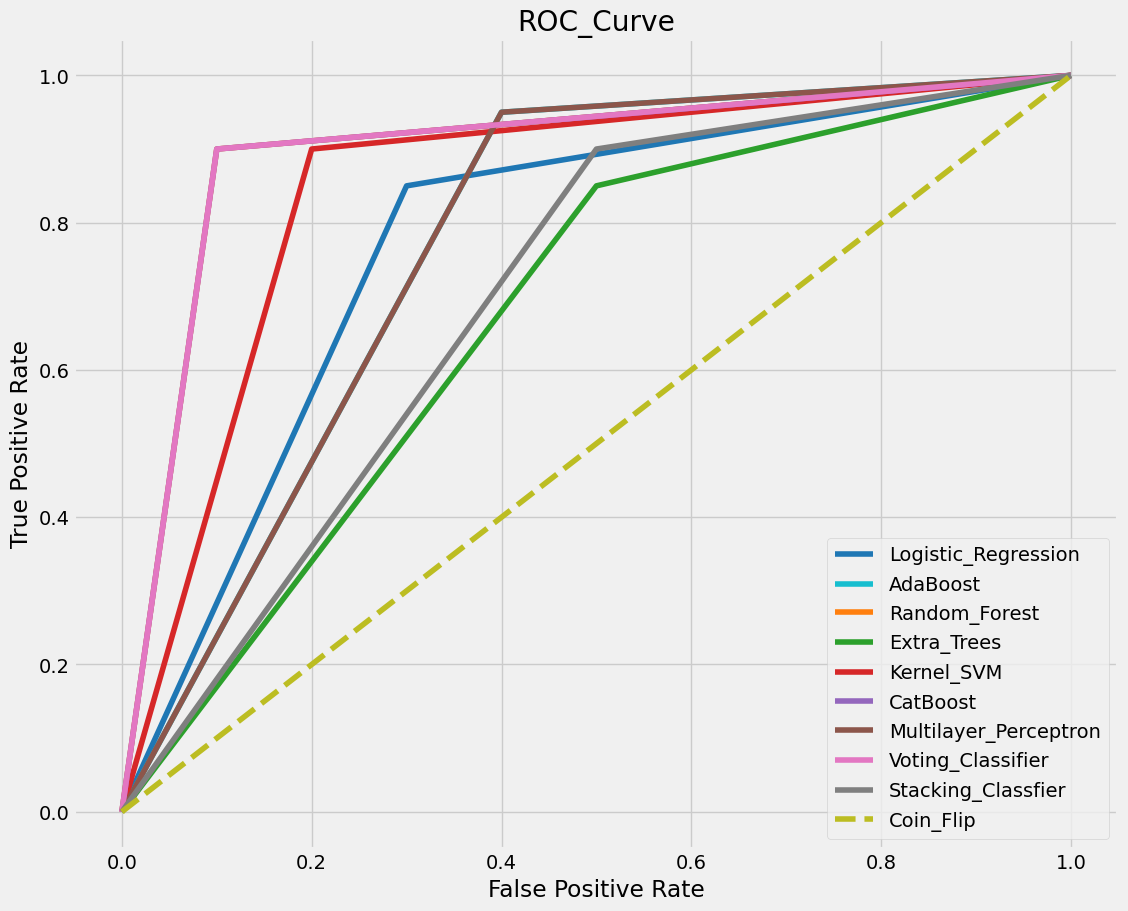

In [142]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_ABC, tpr_ABC, linestyle='-', color='tab:cyan', label='AdaBoost')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([-0.05, 1.05])
plt.ylim([-.05, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

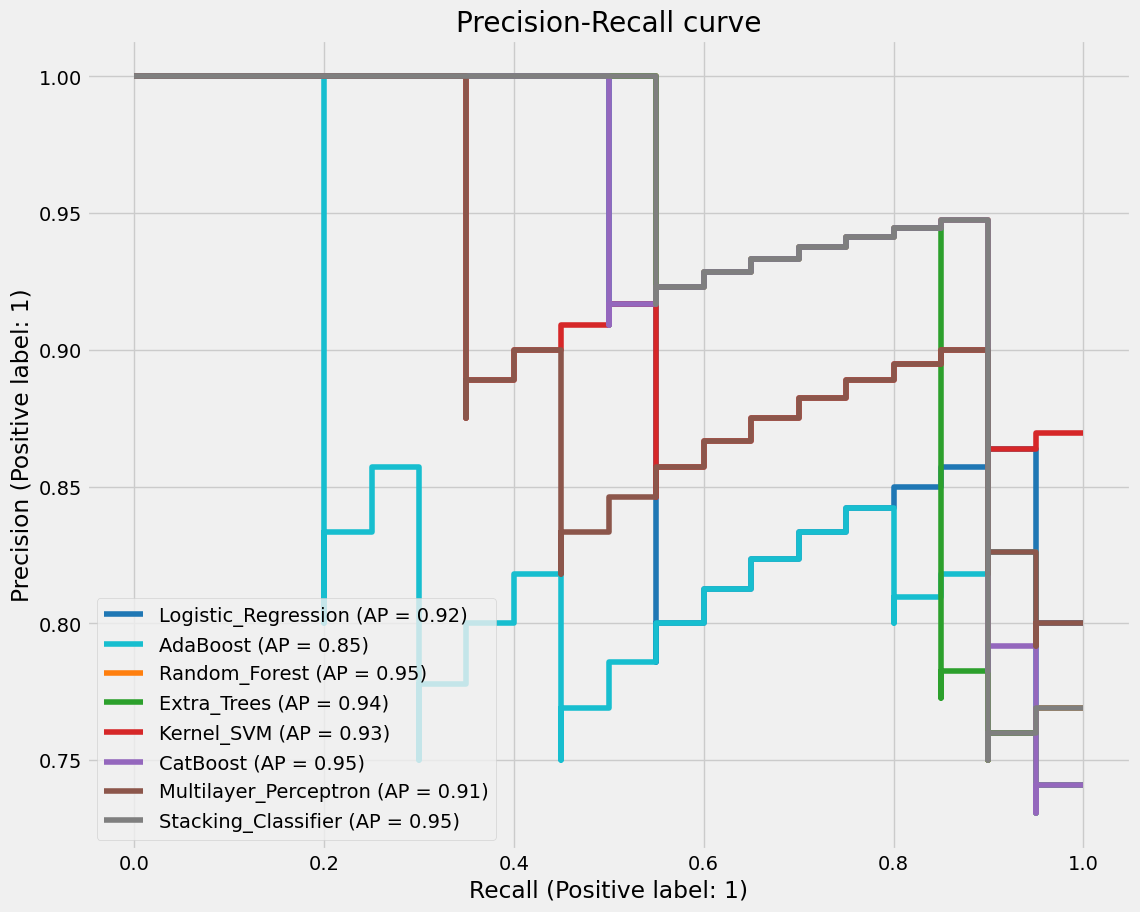

In [143]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(ABC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:cyan', name = "AdaBoost")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()

#### SHAP Model Explainer

In [144]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [145]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


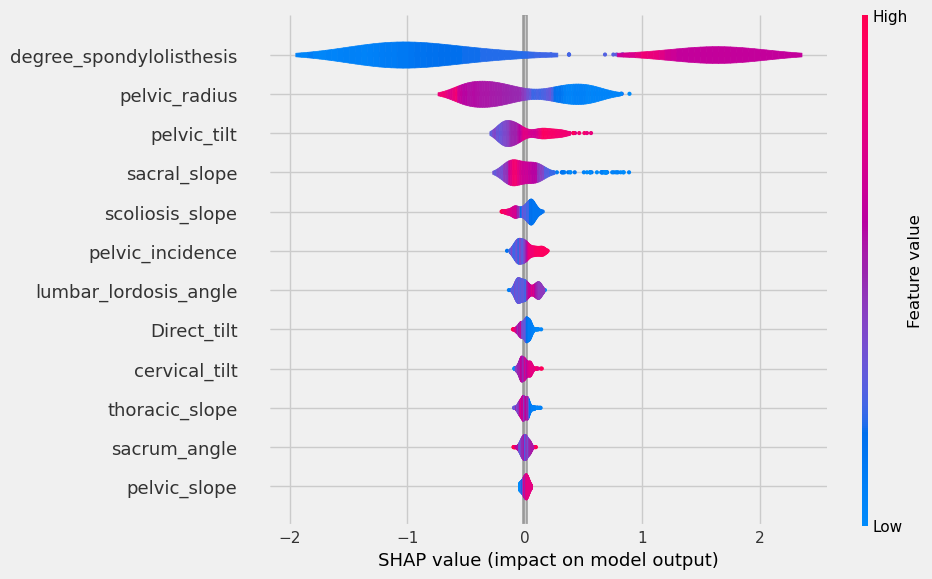

In [146]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [147]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [148]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [149]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V3.0_LowerBackPain.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass

[NbConvertApp] Converting notebook GS_MLM_CLF_V3.0_LowerBackPain.ipynb to html_toc
[NbConvertApp] Support files will be in MLM_V3.0_LowerBackPain_I1_files\
[NbConvertApp] Making directory MLM_V3.0_LowerBackPain_I1_files
[NbConvertApp] Making directory MLM_V3.0_LowerBackPain_I1_files
[NbConvertApp] Making directory MLM_V3.0_LowerBackPain_I1_files
[NbConvertApp] Writing 694617 bytes to MLM_V3.0_LowerBackPain_I1.html
